<a href="https://colab.research.google.com/github/JuanM-GG/sistemas-dinamicos-Python/blob/main/continuous_product_blending.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Título: Continuous Product Blending

Nombre: Juan Manuel G.G

Fecha: 21 de diciembre del 2020

This case study is modeled after an actual process used to prepare an over-the-counter pediatric medication. The situation has been simplified to the dissolution of a single active ingredient into a suspension, and adapted to continouous rather than batch operation.

The process objective is to mix an active ingredient $A$ into a suspension $S$, providing enough time to fully mix and dissolve components coming from both streams. The feed concentration of $A$ is 200 grams/liter. Process requirements include:

* The final product concentration must be in the range 7.8 to 8.2 grams/liter. 
* At all timses the mixer residence time, $\frac{V}{q_{out}}$, must remain between 84 and 108 hours.
* The volume cannot exceed the tank capacity of 15,000 liters, and cannot fall below the 8,000 liters required to fully cover the mixing blades.

The outlet from the tank is fed directly to a packaging line. The flow demand can vary due to changes in speed of the packaging equipment.

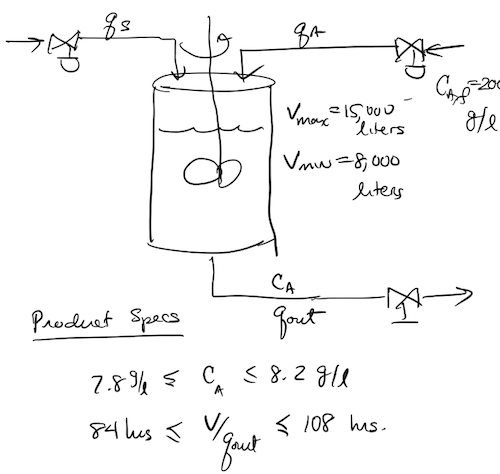

## Análisis preliminar

### Parameters

| Quantity | Symbol | Value | Units |
|:-:|:-:|:-:|:-:|
| Feed Concentration |$c_{A,f}$ | 200 | g/liter |
| Maximum Tank Operating Capacity | $V$ | 15,000 | liters |
| Minimum Tank Operating Capacity | $V$ | 8,000 | liters |

### Control Objectives

* Maintain outlet concentration of $A$ at $8.0 \pm 0.2$ grams/liter.
* Maintain an average residence time (i.e., ratio $V/q_{out}$) of $96 \pm 12$ hours.
* Past operation has shown a liquid volume of 12,000 liters generally meets nominal demand. Demand, however, fluctuates and is determined by the downstream packaging line.

### Classification of Variables

What are the disturbances variables (DV), manipulated variables (MV), and controlled variables (CV)?

| Variable | Symbol | Classification |
|:-:|:-:|:-:|
| Outlet Flow | $q_{out}$ | DV |
| Feed Flow | $q_A$ | MV |
| Water Makeup Flow | $q_W$ | MV |
| Product Concentration | $c_A$ | CV |
| Volume | $V$ | CV |

### Degrees of Freedom Analysis

At steady-state the balance equations become algebraic equations

\begin{align}
0 & = \bar{q}_A + \bar{q}_S - \bar{q}_{out} \\
& \\
0 & = \bar{q}_A c_{A,f} - \bar{q}_{out}\bar{c}_A
\end{align}

There are a total of five variables in these two equations. So we need to find at least three more specifciations or constraints to determine values for these variables. 

Additional pieces of information we have are the process specifications

\begin{align}
\frac{\bar{q}_{out}}{\bar{V}} & = 96 \mbox{ hours} \\
c_{A,f} & = 200 \mbox{ g/liter} \\
\bar{q}_{out} & = \mbox{ set by the downstream demand} \\
\bar{c}_A & = 8 \mbox{ g/liter}
\end{align}

This is a total of four new equations for steady-state.  The new equations introduced an additional variable $\bar{V}$. This provides six variables in six equations provided we know the downstream demand.

### Steady State

Let's assume a constant output demand $\bar{q}_{out}$ = 125 liters/hr.  The equations may then be solved in order:

\begin{align}
c_{A,f} & = 200 \mbox{ g/liter} \\
\bar{c}_A & = 8 \mbox{ g/liter} \\
\bar{V} & = 96\ \bar{q}_{out} = 12,000 \mbox{ liters}\\
\bar{q}_A & = \frac{\bar{q}_{out}\bar{c}_A}{c_{A,f}} = 5 \mbox{ liters/hr}\\
\bar{q}_S & = \bar{q}_{out} - \bar{q}_A = 120 \mbox{ liters/hr}
\end{align}

### Exercise 1. Determine Operating Range

Solve the steady-state equations for other values of $\bar{q}_{out}$. Given a maximum tank operating capacity of 15,000 liters, what is the largest possible value of $\bar{q}_{out}$ which still meets process specifications?  If the minimum tank operating capacity is 8,000 liters, what is the minimum value of $\bar{q}_{out}$?

In [2]:
def steady_state(qout):
  Caf = 200.0
  Ca = 8.0
  V = 96*qout
  qa = (qout*Ca)/Caf
  qs = qout - qa
  return [Caf, Ca, V, qa, qs]

In [3]:
steady_state(125)

[200.0, 8.0, 12000, 5.0, 120.0]

$$\frac{V}{q_{out}} > 84 $$

$$\frac{V}{84} > q_{out} $$


$$q_{out} = \frac{V}{84}  = \frac{15000L}{84h}$$

$$q_{out,max} = 178.5714 L/h$$

$$\frac{V}{q_{out}} > 108$$

$$\frac{V}{108} > q_{out}$$


$$q_{out} = \frac{V}{108} = \frac{8000L}{108h}$$

$$q_{out} = 74.074L/h$$

## Modelado 

Las ecuaciones del balance son 

\begin{align}
\frac{dV}{dt} = & = q_A + q_S - q_{out} \\
\frac{d(V c_A)}{dt} = & = q_A c_{A,f} - q_{out} c_A
\end{align}

Where we have made the assumption of constant density among all of the streams, and of complete and uniform mixing in the stirred tank 

\begin{align}
\frac{dV}{dt} & = q_A + q_S - q_{out} \\
\frac{d c_A}{dt} & = \frac{q_A}{V} \left( c_{A,f} - c_A \right) - \frac{q_S}{V} c_A 
\end{align}

## Simulación  

### 1.Importar librerías 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

### 2.Valor de parámetros 

It is a good coding practice to include all relevant parameter values in single block of code.

In [5]:
# Parámetros
caf = 200.0 # g/L
Vmax = 15000 # L
Vmin = 8000 # L 

# Process setpoints 
ca_SP = 8.0 # g/L
rtime_SP = 96 # residence time in hours

# Nominal values of the disturbance variables
qout_bar = 125.0

### 3. Computing steady sate

A good modeling practice is to beging with the determination of a nominal steady state. By nominal we mean operating conditions representative of typical desired behavior of the process in question, and should be computed based on the parameter values given above

In [6]:
# Nominal steady state of the process setpoint
V_bar = rtime_SP*qout_bar
ca_bar = ca_SP
qa_bar = ca_SP*qout_bar/caf
qs_bar = qout_bar - qa_bar

print("Steady Sate")
print(" V[L] ", V_bar)
print(" ca[g/L] ", ca_bar)
print(" qa[L/h] ", qa_bar)
print(" qs[L/h] ", qs_bar)

Steady Sate
 V[L]  12000.0
 ca[g/L]  8.0
 qa[L/h]  5.0
 qs[L/h]  120.0


### 4. Process Model Equations

For simulation with Python function odeint, the model is encapsulated into Python function that accepts twp arguments. 

x is a list of values for the model state, in this case V and ca.
t a variable containing value corresponding to the current time.

In [7]:
def deriv(X, t):
    V, ca = X
    dV = qa + qs - qout
    dca = qa*(caf - ca)/V - qs*ca/V
    return [dV, dca]

### 5. Numerical Solution of the Process Model

Here we establish values for all degrees of freedom, specify initial conditions, and then proced to compute a history of the process behavior. The history is broken into discrete time steps which is a bit more work now, but will later provide a means to test implementations of control algorithms.

In [8]:
# Fix all degrees of freedom 

qout = qout_bar
qa = qa_bar
qs = qs_bar

# Establish initial conditions
t = 0
V = V_bar
ca = ca_bar

# Time step, and variable to store simulation record (or history)
dt = 1
history = [[t,V,ca]]

In [9]:
while t < 500:
  V,ca = odeint(deriv, [V,ca], [t,t + dt])[-1]
  t +=dt
  history.append([t,V,ca])
  history[0:10]

###6. Visualization

In [10]:
def plot_history(history, labels):
  history = np.array(history)
  t = history[:,0]
  n = len(labels) - 1
  plt.figure(figsize=(8,1.95*n))
  for k in range(0,n):
    plt.subplot(n,1,k+1)
    plt.plot(t,history[:,k+1])
    plt.title(labels[k+1])
    plt.xlabel(labels[0])
    plt.grid()
  plt.tight_layout()

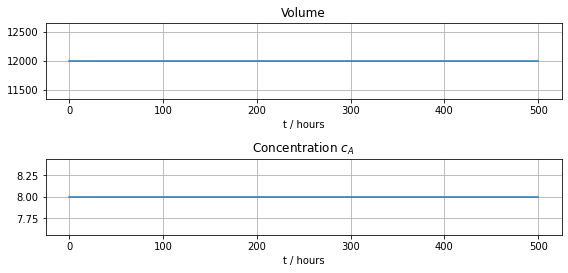

In [11]:
plot_history(history, ["t / hours", "Volume", "Concentration $c_A$"])

## Explore Dynamical Behavior

Let's explore the behavior of this mixing tank under different assumptions. We'll explore the following cases: 

1. The startup concetration of A is $c_A = 0$. How long before the mixer is producing an acceptable product?

2. The outlet flow increases by 10%. How long before the product is out of spec?

3. The outlet flow decreases by 10%. How long before the product is out of spec?

In [12]:
# Fix all degrees of freedom
qout = qout_bar
qa = qa_bar
qs = qs_bar

# Establish initial conditions
t = 0
V = V_bar
ca = 0 # <=================== CHANGED TO AN INITIAL CONDITION OF ZERO

# Time step, and variable to store simulation record (or history)
dt = 1
history = [[t,V,ca]]

In [13]:
while t < 500:
  V,ca = odeint(deriv, [V,ca], [t,t+dt])[-1]
  t += dt
  history.append([t,V,ca])
  

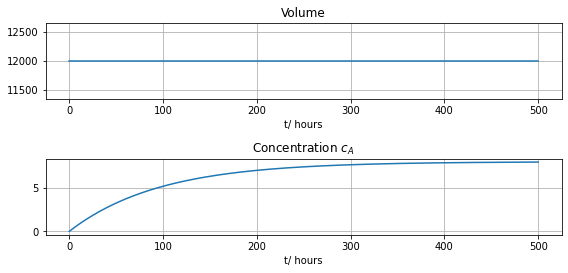

In [14]:
plot_history(history, ["t/ hours","Volume","Concentration $c_A$"])

## Control Residence Time 

We know even small changes in the outlet flowrate results in substantial loss due to out of spec product. Let's try a control strategy in which we change in the suspension flowrate, $q_S$, to compensate for excursion from the desired value of residence time. 

We'll try proportional control where the change in $q_S$ is proportional to the difference of the residence time from the setpoint.

$$ q_S = \bar{q}_S - K \left(\frac{V}{q_{out}} - \frac{\bar{V}}{\bar{q}_{out}} \right)$$

In the following cell e will decrease $q_{out}$ by 10%, and attemp to find a value for K that provides satisfactory control. 

In [15]:
# Fix all degrees of freedom
qout = qout_bar
qa = qa_bar
qs = qs_bar

# Establish initial conditions
t = 0
V = V_bar
ca = ca = ca_bar

# Time step, and variables to store simulation record (or history)
dt = 1.0
history = [[t,V,ca,V/qout, qs]]
qout = 0.9*qout_bar

In [16]:
while t < 500:
  qs = qs_bar - 5*(V/qout -   V_bar/qout_bar)
  V, ca = odeint(deriv, [V,ca],[t,t+dt])[-1]
  t += dt
  history.append([t,V,ca,V/qout,qs])

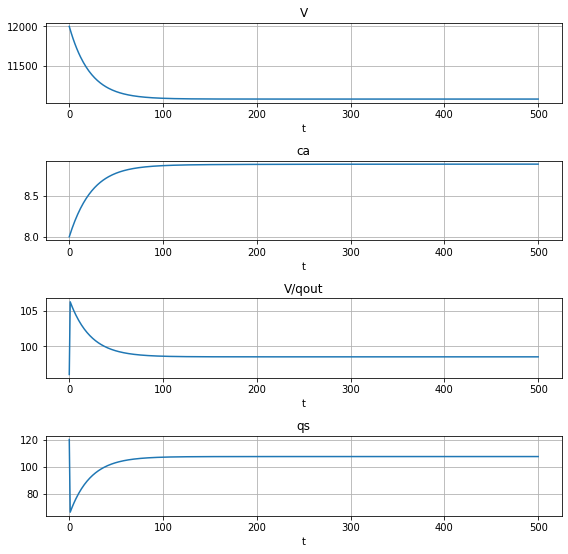

In [17]:
plot_history(history, ["t","V","ca","V/qout","qs"])

## Control concentration

It isn't enough to control only residence time. In fact, controlling residence time in response to a decrease in output causes the outlet concentration to increase beyond the product quality limits. We propose to fix this problem by controlling $q_A$, the inlet of A. A proportional control rule is given by

$$q_A = \bar{q}_A - K \left( c_A - \bar{c}_A \right)$$

where, again, we predict a decrease in $q_A$ is nedeedto compensate for a positive excursion in $c_A$

In [18]:
# fix all degrees of freedom 
qout = qout_bar      # outlet flow -- process disturbance variable.
qa = qa_bar          # inlet flow of A -- process manipulated variable
qs = qs_bar          # inlet flow of suspension -- process manipulated variable

# establish initial conditions
t  = 0
V  = V_bar
ca = ca_bar

# time step, and variable to store simulation record (or history)
dt = 1
history = [[t, V, ca, V/qout, qs, qa]]

qout = 0.9*qout

In [19]:
while t < 500:
  qs = qs_bar - 5*(V/qout - V_bar/qout_bar)
  qa = qa_bar - 3*(ca - ca_bar)
  V, ca = odeint(deriv, [V,ca], [t,t+dt])[-1]
  t += dt
  history.append([t,V,ca,V/qout,qs,qa])

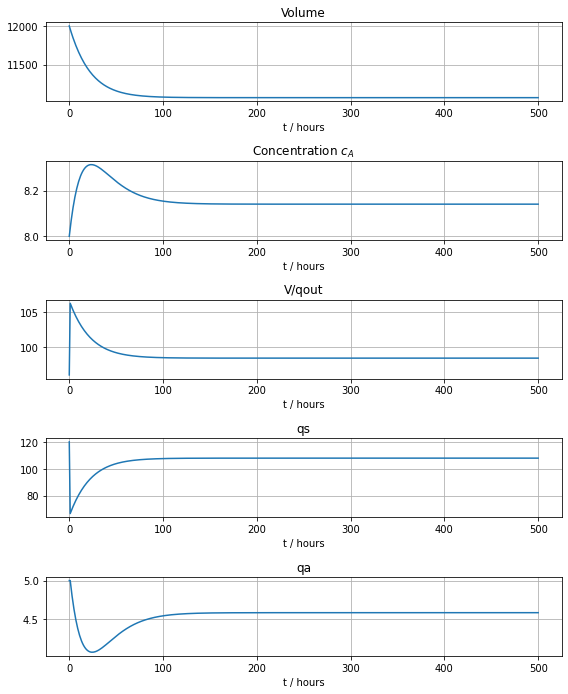

In [20]:
plot_history(history, ["t / hours","Volume","Concentration $c_A$","V/qout","qs","qa"])

## Proportional-Integral Control

The above control laws do a reasonable job of control, but do not return the system to a desired steady-state operating condition. How can we modify the control laws?

\begin{align}
q_A & = \bar{q}_A - K_p \left(c_A - \bar{c}_A \right) - K_i \int_0^t \left(c_A - \bar{c}_A \right) dt
\end{align}

The second term will integrate any constant offset to produce a constantly changing value.  So the only possible steady-state is when $c_A = \bar{c}_A$.

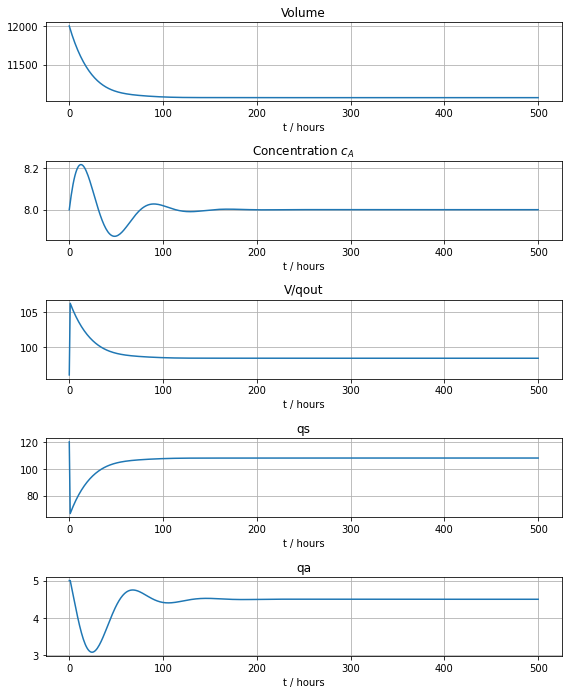

In [21]:
qout = qout_bar      # outlet flow -- process disturbance variable.
qa = qa_bar          # inlet flow of A -- process manipulated variable
qs = qs_bar          # inlet flow of suspension -- process manipulated variable

# establish initial conditions
t  = 0
V  = V_bar
ca = ca_bar
error_sum = 0

# time step, and variable to store simulation record (or history)
dt = 1
history = [[t, V, ca, V/qout, qs, qa]]

qout = 0.9*qout
while t < 500:
    qs = qs_bar - 5*(V/qout - V_bar/qout_bar)
    
    error = (ca - ca_bar)
    error_sum += error * dt
    
    qa = qa_bar - 3*error - 0.4*error_sum
    V, ca = odeint(deriv, [V, ca], [t, t+dt])[-1]
    t += dt
    history.append([t, V, ca, V/qout, qs, qa])

plot_history(history, ['t / hours','Volume','Concentration $c_A$','V/qout','qs','qa'])